# PROJECT 16 흐린 사진을 선명하게 (SRGAN 활용하기)

## [ 배경 지식 ]

저해상도 영상을 고해상도 영상으로 변환하는 작업을 **Super Resolution** 이라고 합니다.

Super Resolution 방법 : Interpolation, SRCNN, SRGAN

### 1. Interpolation
알려진 값을 가진 두 점 사이의 값이 얼마인지를 추정하는 기법  
![interpolation](image/interpolation.jpg)
*(출처 : https://wowcat.tistory.com/2369)*

### 2. SRCNN (Super Resolution Convolution Neural Network)
SRCNN 은 Super Resolution 에 CNN 을 활용한 모델입니다. SRCNN은 아래 이미지와 같은 구조를 가집니다.  
![SRCNN](image/SRCNN.png)
*(출처: https://deepai.org/publication/deep-learning-for-single-image-super-resolution-a-brief-review)*  

> 1. 저해상도 이미지(LR) 을 Interpolation 하여 원하는 이미지 크기로 늘리고, SRCNN 의 입력으로 사용합니다.  
2. 세 개의 Convolution layer 를 거쳐 고해상도 이미지(HR) 를 생성합니다.

### 3. SRGAN (Super Resolution Generative Adversarial Network)
SRGAN 은 Super Resolution 에 GAN 을 활용한 모델입니다.  
SRGAN 은 아래 이미지와 같이 생성자 모델과 판별자 모델의 구조를 가집니다.
![N_CN](image/GN_CN.png)
[출처: https://arxiv.org/pdf/1609.04802.pdf]  
> Generator : 저해상도 이미지(LR) 를 입력으로 받아 가짜 고해상도 이미지(SR) 를 생성합니다.  
Discriminator : 생성된 가짜 고해상도 이미지(SR) 와 실제 고해상도 이미지(HR) 중 진짜를 판별합니다.

$${l}^{SR} = {{l}_{X}^{SR}} + {10}^{-3}{{l}_{Gen}^{SR}}$$  

위 식은 SRGAN 에서 사용하는 손실함수 입니다. 더하기 부호를 기준으로 왼쪽이 content loss, 오른쪽이 adversarial loss 입니다.  
content loss 는 VGG 모델을 사용하여 추출하고, adversarial loss 는 GAN 을 사용하여 추출합니다.  

### 4. Super Resolution 결과 평가하기
Super Resolution 결과는 PSNR 과 SSIM 모델을 사용하여 평가합니다.  

> PSNR (Peak Signal-to-Noise Ratio)  
영상 내 신호가 가질 수 있는 최대 신호에 대한 잡음의 비율을 나타냅니다.  
일반적으로 영상을 압축했을때, 화질이 얼마나 손실되었는지 평가하는 목적으로 사용됩니다.  
데시벨 단위를 사용하며, PSNR 수치가 높을수록 원본 영상에 비해 손실이 적다는 것을 의미합니다.  

> SSIM (Structural Similarity Index Map)  
영상의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산합니다.  
특정 영상에 대한 SSIM 값이 높을수록 원본 영상의 품질에 가깝다는 것을 의미합니다.  

결국 PSNR 과 SSIM 결과가 높을수록 비교하려는 영상이 원본 영상 품질에 가깝다는 것을 의미합니다.

## STEP 1. 직접 고른 이미지로 SRGAN 실험하기

### 1) 고해상도 이미지 interpolation 하여 SRGAN 적용하기

- 높은 해상도를 가진 이미지 불러오기

height : 1800, width : 1200


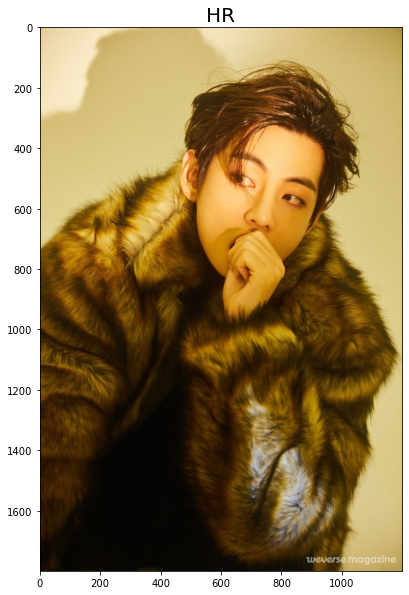

In [1]:
from skimage import data
import matplotlib.pyplot as plt
import os
import cv2

img_path = os.getenv("HOME") + "/aiffel/exploration/super_resolution/image/"
hr_image = cv2.cvtColor(cv2.imread(img_path + "V.jpg", 1), cv2.COLOR_BGR2RGB)
h = hr_image.shape[0]
w = hr_image.shape[1]

print(f"height : {h}, width : {w}") # 이미지의 크기를 출력합니다.

plt.figure(figsize=(10,10))
plt.imshow(hr_image)
plt.title("HR", fontsize=20)
plt.show()

- 불러온 이미지에 bicubic interpolation 을 적용해 가로 및 세로 픽셀 수 1/4로 줄이기

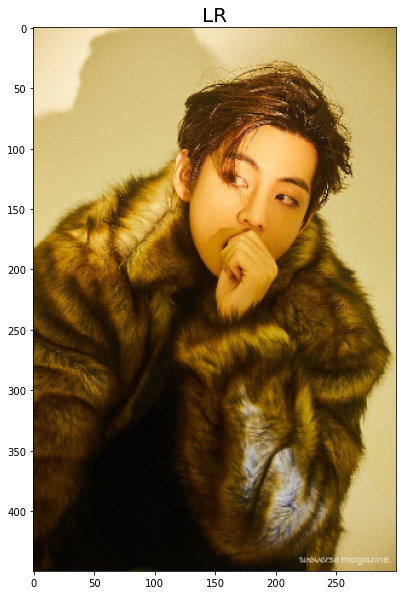

In [3]:
lr_image = cv2.resize(
    hr_image, 
    dsize=(w//4, h//4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

plt.figure(figsize=(10,10))
plt.imshow(lr_image)
plt.title("LR", fontsize=20)
plt.show()

- 픽셀을 줄인 저해상도 이미지를 입력으로 SRGAN 을 이용해 고해상도 이미지 생성하기

In [4]:
import tensorflow as tf

model_file = os.getenv('HOME')+'/aiffel/exploration/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_image = apply_srgan(lr_image)

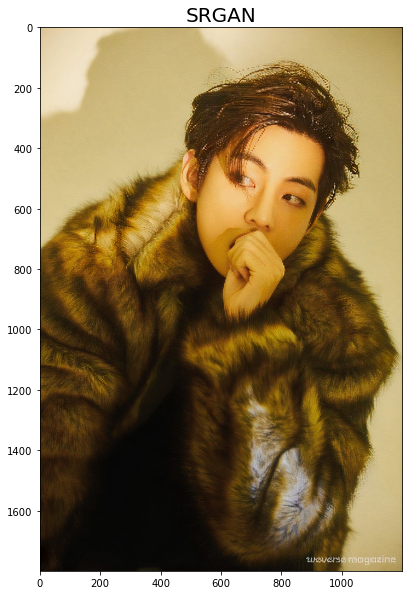

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(srgan_image)
plt.title("SRGAN", fontsize=20)
plt.show()

- 픽셀을 줄인 저해상도 이미지에 bicubic interpolation 을 적용해 가로 및 세로 픽셀 수 4배로 늘리기

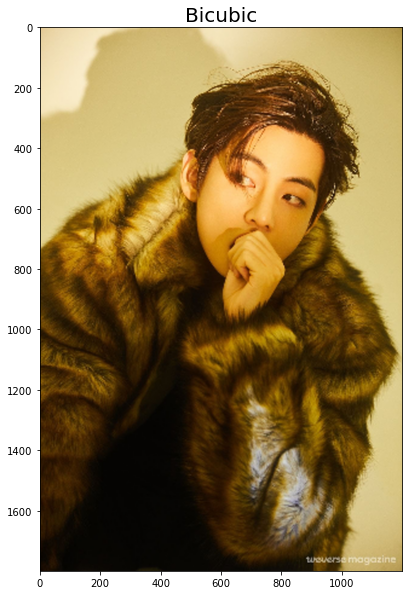

In [7]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(w, h), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

plt.figure(figsize=(10,10))
plt.imshow(bicubic_image)
plt.title("Bicubic", fontsize=20)
plt.show()

- bicubic interpolation 의 결과, SRGAN 의 결과, 원래 고해상도 이미지 나란히 시각화하기

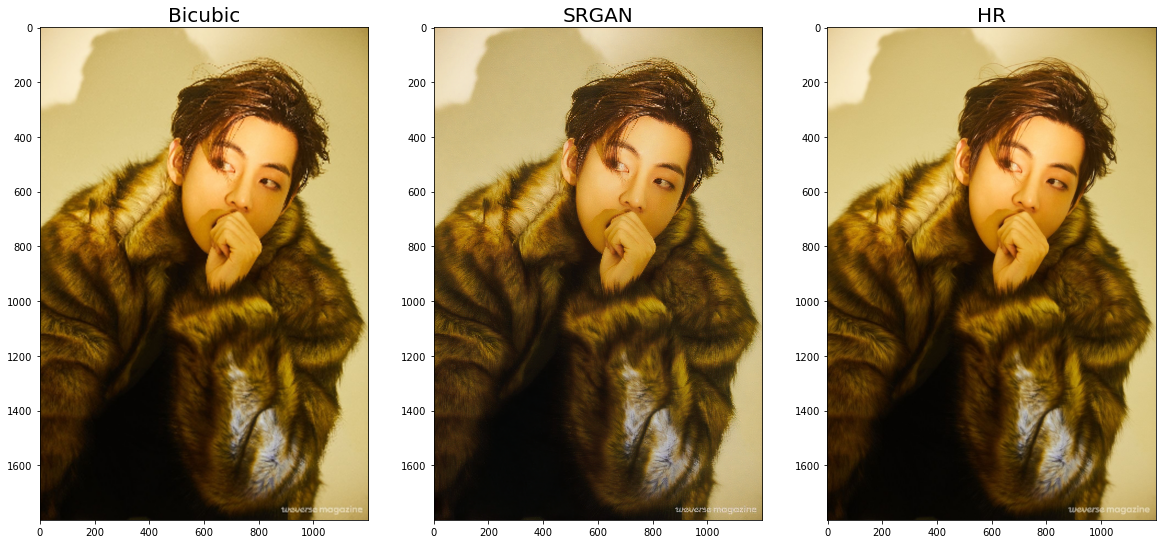

In [8]:
images = [bicubic_image, srgan_image, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20,20))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

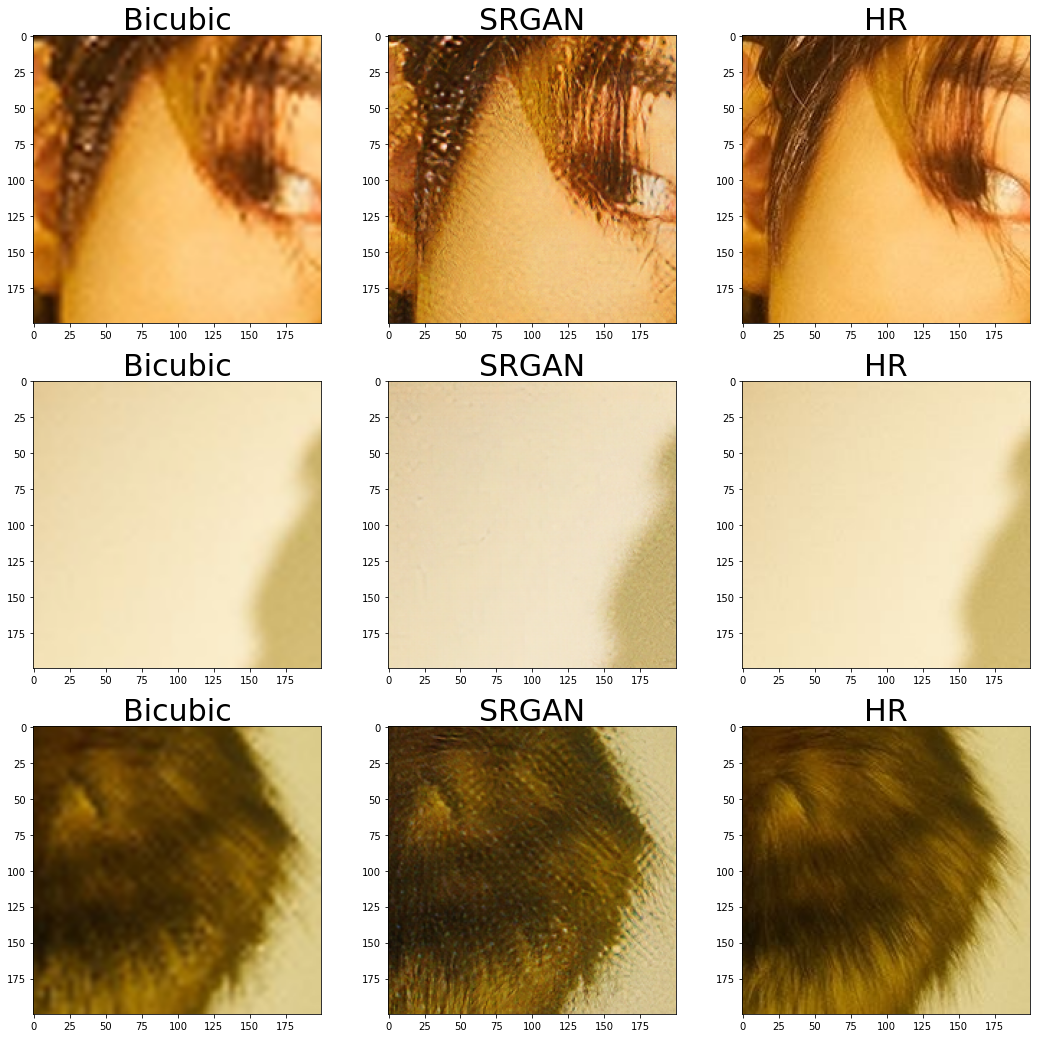

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (0,0), (1000,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 200, 200)
    img2 = crop(srgan_image , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

- 결과 해석하기

bicubic, srgan, hr 의 이미지를 전체적으로 보았을때, bicubic 이미지보다 srgan 이미지가 hr 이미지와 가장 비슷합니다.  
각각의 이미지의 부분을 확인해보니, bicubic 이미지는 그냥 화질이 안좋은 이미지, srgan 이미지는 bicubic 이미지보다는 선명한 것 같지만 hr 이미와는 거리가 먼것 같으면서도 가까운것 같은 느낌이 듭니다. srgan 이미지는 hr 이미지의 디테일한 부분은 잘 살려내지 못하는 것 같습니다.

### 2) 저해상도 이미지 SRGAN 적용하기

- 낮은 해상도를 가진 이미지 불러오기

height : 274, width : 182


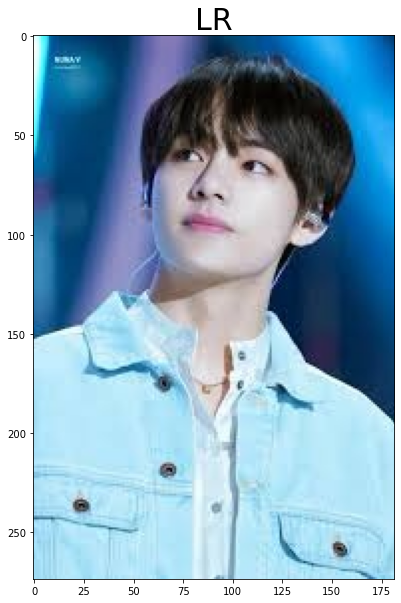

In [10]:
from skimage import data
import matplotlib.pyplot as plt
import os
import cv2

img_path = os.getenv("HOME") + "/aiffel/exploration/super_resolution/image/"
lr_image = cv2.cvtColor(cv2.imread(img_path + "V2.JPG", 1), cv2.COLOR_BGR2RGB)
h = lr_image.shape[0]
w = lr_image.shape[1]

print(f"height : {h}, width : {w}") # 이미지의 크기를 출력합니다.

plt.figure(figsize=(10,10))
plt.imshow(lr_image)
plt.title("LR", fontsize=30)
plt.show()

- 불러온 이미지를 입력으로 SRGAN 을 이용해 고해상도 이미지 생성하기

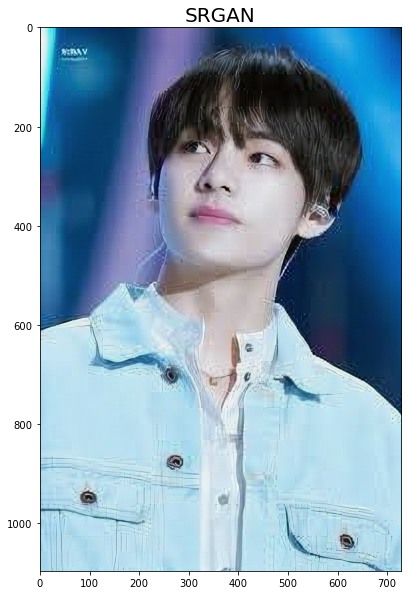

In [11]:
srgan_image = apply_srgan(lr_image)

plt.figure(figsize=(10,10))
plt.imshow(srgan_image)
plt.title("SRGAN", fontsize=20)
plt.show()

- 낮은 해상도를 가진 이미지에 bicubic interpolation 을 적용해 가로 및 세로 픽셀 수를 4배로 늘립니다.

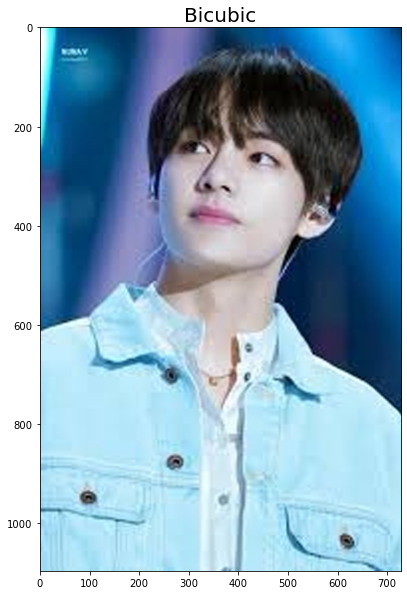

In [12]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(w*4, h*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

plt.figure(figsize=(10,10))
plt.imshow(bicubic_image)
plt.title("Bicubic", fontsize=20)
plt.show()

- bicubic interpolation 의 결과, SRGAN 의 결과 나란히 시각화하기

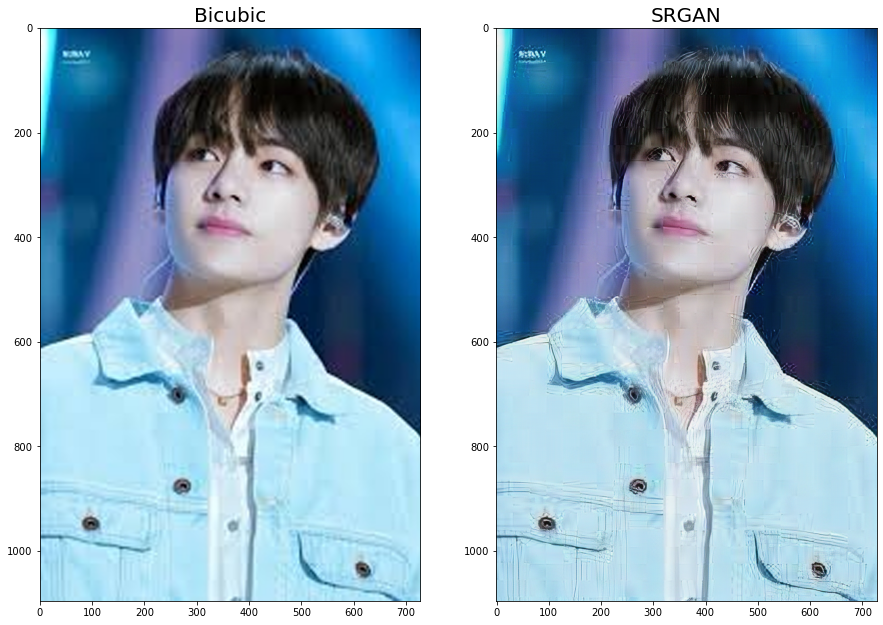

In [13]:
images = [bicubic_image, srgan_image]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(15,15))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

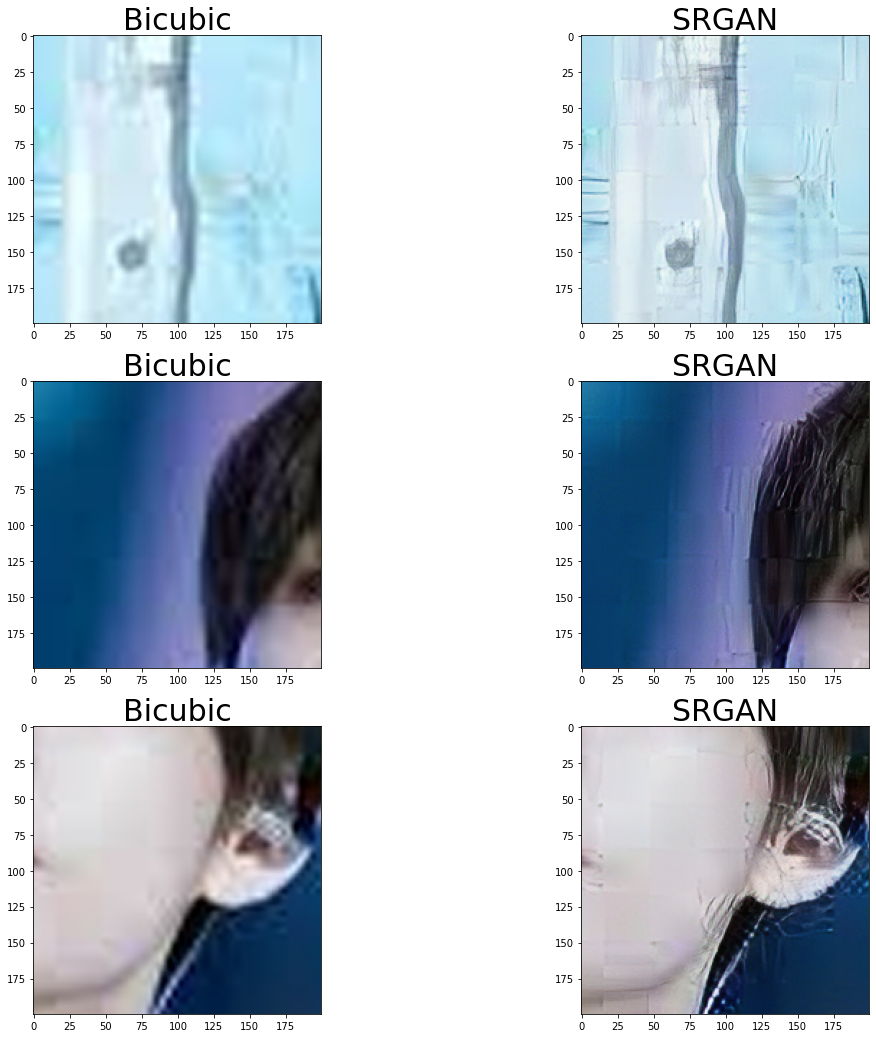

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(800,300), (100,100), (300,400)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 200, 200)
    img2 = crop(srgan_image , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

- 결과 해석하기

bicubic, srgan 의 이미지를 전체적으로 보았을때, bicubic 이미지보다 srgan 이미지가 더 화질이 좋아보입니다.   
각각의 이미지의 부분을 확인해보니, bicubic 이미지보다 srgan 이미지가 더 선명한 것을 확인할 수 있습니다. (피부, 머리결 등)

## STEP2. SRGAN 을 이용해 고해상도 gif 생성하기

이미 학습된 SRGAN 을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해보도록 하겠습니다.

SRGAN 을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 보도록 하겠습니다.

#### 1) gif 파일 불러오기

gif 파일은 아래 코드를 통해 각 프레임(이미지)를 불러올 수 있습니다. frames 는 리스트 안에 각각의 프레임이 들어있습니다.

In [15]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("image/metro_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

h = frames[0].shape[0]
w = frames[0].shape[1]

frame 수 : 35
frame 크기 : (252, 282, 3)


#### 2) 프레임 별 Super Resolution 진행하기

bicubic interpolation 과 SGRAN 을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘립니다.  
Super Resolution 이 완료된 각각의 결과를 리스트 frames_sr 에 넣습니다.

In [16]:
frames_bicubic = []
frames_srgan = []

for image in frames:    
    bicubic_image = cv2.resize(
        image, 
        dsize=(w*4, h*4), # (가로 픽셀 수, 세로 픽셀 수)
        interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
    )
    frames_bicubic.append(bicubic_image)
    
    srgan_image = apply_srgan(image)
    frames_srgan.append(srgan_image)

#### 3) 프레임 합쳐서 gif 만들기

frames_sr 을 가지고 gif 파일을 생성합니다.  
bicubic 및 SRGAN 의 결과를 각각 저장하여 2개의 파일을 만듭니다.

In [17]:
import imageio

imageio.mimsave("image/bicubic.gif", frames_bicubic)
imageio.mimsave("image/srgan.gif", frames_srgan)

#### 4) Jupyter notebook 에 gif 표시하기

저해상도 gif 와 고해상도 gif 파일을 출력합니다.  

저해상도 : https://drive.google.com/file/d/112PGQFS-B4s1qnOZH8UWmzItj4GAaCpp/view?usp=sharing

고해상도 : https://drive.google.com/file/d/1P0mto-P2FHiLnS3KPsSTtRMosTeQTSJi/view?usp=sharing

## [ 결과 - 루브릭 ]
**1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.**
- SRGAN을 통해 생성된 이미지를 제출하였습니다. :)  

**다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.** 
- 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였습니다. :)
  
**3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.**
- 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능합니다. :)